# <font color="RoyalBlue">Energy Price Prediction - Introduction</font>

This project is part of a university course and focuses on <b>predicting electricity prices</b> using Python and Jupyter Notebooks. For now, only the hourly <b>EPEX SPOT day-ahead prices of germany</b> are covered. After a quick data analysis, several machine learning and time series models (SARIMA, Prophet, XGBoost, LSTM) are trained, evaluated and finally compared.

Table of Contents of this Notebook: (TODO: update this)
1) Importing Libraries
2) Loading the Data
3) Merging the Data Frames
4) Exploratory Data Analysis (EDA)
5) Data Preparation
6) Feature Engineering
7) Model Training and Prediction
8) Model Evaluation and Comparison
9) Conclusion

# <font color="RoyalBlue">1 Importing Libraries</font>
First of all, we import all necessary libraries required for data analysis, machine learning models and data visualization. This is also where we can set a plot design that will be applied for Seaborn and Pyplot.

In [1279]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Time Series Models
from xgboost import XGBRegressor
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-Learn Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Holidays
import holidays

# Time and Date
import datetime

# Simple plot design
print(plt.style.available)
sns.set_style('darkgrid')
sns.set_palette("bright")

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


After importing all these libraries, let's load some data in the next chapter. This data will then be used to train our model in the final chapters of this Notebook.

# <font color="RoyalBlue">2 Loading the Data</font>

Note, that all data used refers exclusively to the German price zone of the EPEX Spot electricity market. For this, we use a total of three different csv files in order to retreive our data. Firstly, each csv files content will be saved in its own Pandas DataFrame. Later on, they will all be merged together into just one DataFrame by using their date and hour column as a primary key. However, before merging, we take a brief look at each DataFrame and remove unnecessary and redundant information that could damage our model prediction. Moreover, we address certain challenges such as converting data types and handling the German daylight saving time transitions. All of this will be covered throughout this second chapter.

## EPEX Spot Price Data
The first data set contains the hourly EPEX Spot prices and looks as follows:

In [1280]:
df_prices = pd.read_csv("../data/germany_epex_spot.csv")

# Print data types and first five rows
print(df_prices.dtypes)
df_prices.head()

Country              object
ISO3 Code            object
Datetime (UTC)       object
Datetime (Local)     object
Price (EUR/MWhe)    float64
dtype: object


,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Germany,DEU,2015-01-01 00:00:00,2015-01-01 01:00:00,22.34
1,Germany,DEU,2015-01-01 01:00:00,2015-01-01 02:00:00,22.34
2,Germany,DEU,2015-01-01 02:00:00,2015-01-01 03:00:00,22.34
3,Germany,DEU,2015-01-01 03:00:00,2015-01-01 04:00:00,22.34
4,Germany,DEU,2015-01-01 04:00:00,2015-01-01 05:00:00,22.34


We can obviously remove the columns `Country`, `ISO3 Code` and `Datetime (UTC)` because they wont be needed for the model training. With regard to merging the individual DataFrames later, we will also rename the column `Datetime (Local)` that represents our primary key to `timestamp`. Furthermore, we need to convert this timestamps data type into a valid datetime type. Because the decimal numbers in the price column have already been in a valid float number format, we do not need to adjust anything here. In fact, all columns containing number values in each of the three csv files are already saved in a valid float value format, so we don't have to take care of this in future.

In [1281]:
# Rename important Columns to snake case format
df_prices = df_prices.rename(columns={
    'Datetime (Local)': 'timestamp',
    'Price (EUR/MWhe)': 'price_eur_per_mwh'
})

# Only keep relevant Columns
df_prices = df_prices[['timestamp', 'price_eur_per_mwh']]

# Convert data type from string to datetime64[ns]
df_prices['timestamp'] = pd.to_datetime(df_prices['timestamp'])

# Print data types and first five rows again
print(df_prices.dtypes)
df_prices.head()

timestamp            datetime64[ns]
price_eur_per_mwh           float64
dtype: object


,timestamp,price_eur_per_mwh
0,2015-01-01 01:00:00,22.34
1,2015-01-01 02:00:00,22.34
2,2015-01-01 03:00:00,22.34
3,2015-01-01 04:00:00,22.34
4,2015-01-01 05:00:00,22.34


## Energy Consumption Forecast Data

The next data set contains information about the energy consumption and includes hourly forecasts for the demand of net load and residual load. The net load represents the total electricity demand at a given time, including all consumers, whereas the residual load refers the the remaining electricity demand that must be met by controllable power plants after subtracting generation from renewable sources like wind and solar. The DataFrame including its current data types looks as follows:

In [1282]:
df_consumption = pd.read_csv("../data/energy_consumption_forecast.csv", delimiter=";", na_values="-") # NaN values are saved as a "-"

# Print data types and first five rows
print(df_consumption.dtypes)
df_consumption.head()

Date from                       object
Date to                         object
Forecast Netload[MWh]          float64
Forecast Residual Load[MWh]    float64
dtype: object


,Date from,Date to,Forecast Netload[MWh],Forecast Residual Load[MWh]
0,01.01.2015 00:00,01.01.2015 01:00,49306.25,41399.00
1,01.01.2015 01:00,01.01.2015 02:00,46952.50,38481.50
2,01.01.2015 02:00,01.01.2015 03:00,45751.50,37152.25
3,01.01.2015 03:00,01.01.2015 04:00,45306.25,36638.50
4,01.01.2015 04:00,01.01.2015 05:00,45423.00,36580.50


Just like with the first DataFrame, we can remove unnecessary columns and rename others. Note the `na_values` parameter in the code above, that is used to tell pandas, that the loaded csv files data uses a single `-` symbol in order to implicate NaN values.

In [1283]:
# Rename important columns to snake case format
df_consumption = df_consumption.rename(columns={
    'Date from': 'timestamp',
    'Forecast Netload[MWh]': 'forecast_net_load_mwh',
    'Forecast Residual Load[MWh]': 'forecast_residual_load_mwh'
})

# Get rid of unnecessary "Date to" column
df_consumption.drop(columns=['Date to'], inplace=True)

# Convert data type from string to datetime64[ns]
df_consumption['timestamp'] = pd.to_datetime(df_consumption['timestamp'], format="%d.%m.%Y %H:%M")

# Print data types and first five rows again
print(df_consumption.dtypes)
df_consumption.head()

timestamp                     datetime64[ns]
forecast_net_load_mwh                float64
forecast_residual_load_mwh           float64
dtype: object


,timestamp,forecast_net_load_mwh,forecast_residual_load_mwh
0,2015-01-01 00:00:00,49306.25,41399.00
1,2015-01-01 01:00:00,46952.50,38481.50
2,2015-01-01 02:00:00,45751.50,37152.25
3,2015-01-01 03:00:00,45306.25,36638.50
4,2015-01-01 04:00:00,45423.00,36580.50


## Power Generation Forecast Data
Finally, we will also include data containing hourly forecasts for energy generation. These include forecasts on solar and wind energy generation as well as `Other Sources`, meaning all remaning energy sources that have not been explicitly stated in other columns, such as biomass, hydropower, nuclear, coal and gas. Again, we print the first five rows of our data as well as its data types:

In [1284]:
df_generation = pd.read_csv("../data/power_generation_forecast.csv", delimiter=";", na_values="-")

# Print data types and first five rows
print(df_generation.dtypes)
df_generation.head()

Date from                         object
Date until                        object
Forecast Total [MWh]             float64
Forecast Wind and Solar [MWh]    float64
Forecast Wind Offshore [MWh]     float64
Forecast Wind Onshore [MWh]      float64
Forecast Solar [MWh]             float64
Forecast Other Sources [MWh]     float64
dtype: object


,Date from,Date until,Forecast Total [MWh],Forecast Wind and Solar [MWh],Forecast Wind Offshore [MWh],Forecast Wind Onshore [MWh],Forecast Solar [MWh],Forecast Other Sources [MWh]
0,01.01.2015 00:00,01.01.2015 01:00,58974.0,7907.25,258.50,7648.75,0.0,51066.75
1,01.01.2015 01:00,01.01.2015 02:00,57681.0,8471.00,258.75,8212.25,0.0,49210.00
2,01.01.2015 02:00,01.01.2015 03:00,56256.0,8599.25,258.50,8340.75,0.0,47656.75
3,01.01.2015 03:00,01.01.2015 04:00,54432.0,8667.75,259.00,8408.75,0.0,45764.25
4,01.01.2015 04:00,01.01.2015 05:00,54522.0,8842.50,260.50,8582.00,0.0,45679.50


Just like before, there is some work to do, such as removing and renaming some columns as well as converting the timestamps data type.

In [1285]:
# Remove unnecessary Columns
df_generation = df_generation.drop(columns=[
    "Date until",
    "Forecast Wind and Solar [MWh]"
])

# Rename important columns to snake case format
df_generation = df_generation.rename(columns={
    'Date from': 'timestamp',
    'Forecast Total [MWh]': 'forecast_total_mwh',
    'Forecast Wind Offshore [MWh]': 'forecast_wind_offshore_mwh',
    'Forecast Wind Onshore [MWh]': 'forecast_wind_onshore_mwh',
    'Forecast Solar [MWh]': 'forecast_solar_mwh',
    'Forecast Other Sources [MWh]': 'forecast_other_mwh'
})

# Convert timstamp to datetime type
df_generation['timestamp'] = pd.to_datetime(df_generation['timestamp'], format="%d.%m.%Y %H:%M")

# Print data types and first five rows again
print(df_generation.dtypes)
df_generation.head()

timestamp                     datetime64[ns]
forecast_total_mwh                   float64
forecast_wind_offshore_mwh           float64
forecast_wind_onshore_mwh            float64
forecast_solar_mwh                   float64
forecast_other_mwh                   float64
dtype: object


,timestamp,forecast_total_mwh,forecast_wind_offshore_mwh,forecast_wind_onshore_mwh,forecast_solar_mwh,forecast_other_mwh
0,2015-01-01 00:00:00,58974.0,258.50,7648.75,0.0,51066.75
1,2015-01-01 01:00:00,57681.0,258.75,8212.25,0.0,49210.00
2,2015-01-01 02:00:00,56256.0,258.50,8340.75,0.0,47656.75
3,2015-01-01 03:00:00,54432.0,259.00,8408.75,0.0,45764.25
4,2015-01-01 04:00:00,54522.0,260.50,8582.00,0.0,45679.50


We have now successfully loaded in our data and obtained three DataFrames, each containing a `timestamp` column. In order to merge these three DataFrames together, we want to ensure that the `timestamp` column is suitable for merging. This will be covered in the next chapter.

# <font color="RoyalBlue">3 Merging the DataFrames</font>

In this section, we will merge all of our DataFrames together into a single DataFrame that will later be used for the model training. Before actually merging, we take a close look at the `timestamp` column of each DataFrame. As part of this, we will be confronted with a small problem: the **German Daylight Saving Time Change**. After handling this problem, we quickly validate that our merge was successful.

## Making sure that we are ready to merge
After loading in the data, creating our DataFrames and converting some data types, we are now theoretically ready to merge them together into just one single DataFrame. However, before that, let's make sure that each DataFrames `timestamp` column is valid to be merged on. We will see that this is not the case right now! The following code block shows some considerations regarding whether we are ready to merge or not by making sure that:
- all DataFrames have a common `timestamp` column
- which is saved as a valid `datetype64`
- and is never `NaN`
- and has no duplicate

In [1286]:
# Make sure that we have a common timestamp column
common_columns = set(df_generation.columns).intersection(df_consumption.columns).intersection(df_prices.columns)
print("Common columns between all DataFrames:", common_columns)

# Let's also make sure that the data type of each timestamp is valid
print("\nData type df_prices['timestamp']:", df_prices['timestamp'].dtype)
print("Data type df_generation['timestamp']:", df_generation['timestamp'].dtype)
print("Data type df_consumption['timestamp']:", df_consumption['timestamp'].dtype)

# Check if timestamp is NaN anywhere
print("\ndf_prices has {} timestamp values that are NaN".format(df_prices['timestamp'].isna().sum()))
print("df_generation has {} timestamp values that are NaN".format(df_generation['timestamp'].isna().sum()))
print("df_consumption has {} timestamp values that are NaN".format(df_consumption['timestamp'].isna().sum()))

# Print the amount of common timestamp values
common_values = set(df_generation['timestamp']).intersection(df_consumption['timestamp']).intersection(df_prices['timestamp'])
print("\nCommon values between all DataFrames:", len(common_values), "\n")

# Check for any timestamp duplicates -> Daylight Saving Time Change!?
print(df_prices[df_prices.duplicated(subset='timestamp')])
print(df_generation[df_generation.duplicated(subset='timestamp')])
print(df_consumption[df_consumption.duplicated(subset='timestamp')])


Common columns between all DataFrames: {'timestamp'}

Data type df_prices['timestamp']: datetime64[ns]
Data type df_generation['timestamp']: datetime64[ns]
Data type df_consumption['timestamp']: datetime64[ns]

df_prices has 0 timestamp values that are NaN
df_generation has 0 timestamp values that are NaN
df_consumption has 0 timestamp values that are NaN

Common values between all DataFrames: 87661 

                timestamp  price_eur_per_mwh
7129  2015-10-25 02:00:00              25.02
16033 2016-10-30 02:00:00              31.55
24769 2017-10-29 02:00:00             -83.00
33505 2018-10-28 02:00:00              44.06
42241 2019-10-27 02:00:00             -10.38
50977 2020-10-25 02:00:00              -6.39
59881 2021-10-31 02:00:00              58.26
68617 2022-10-30 02:00:00              95.29
77353 2023-10-29 02:00:00               7.58
86089 2024-10-27 02:00:00              68.62
                timestamp  forecast_total_mwh  forecast_wind_offshore_mwh  \
7130  2015-10-25 02:00:

## Duplicate Timestamps (Daylight Saving Time)

As seen above, the datasets contain exactly one duplicate timestamp at Hour 02:00 on the last Sunday of October every year. This occurs due to the end of Daylight Saving Time in Germany, when clocks are set back one hour. As a result, the hour between 02:00 and 03:00 appears twice. These duplicate timestamps need to be handled accordingly, for example by using timezone-aware timestamps, removing duplicates, or differentiating them manually. For this project, it is sufficient to just remove these duplicates.

In [1287]:
# Remove duplicates that result from daylight saving time
df_prices = df_prices[~df_prices.duplicated(subset='timestamp')]
df_generation = df_generation[~df_generation.duplicated(subset='timestamp')]
df_consumption = df_consumption[~df_consumption.duplicated(subset='timestamp')]

# Check if there are duplicates left
print("Amount of duplicates in df_prices:", df_prices['timestamp'].duplicated().sum())
print("Amount of duplicates in df_generation:", df_generation['timestamp'].duplicated().sum())
print("Amount of duplicates in df_consumption:", df_consumption['timestamp'].duplicated().sum())

Amount of duplicates in df_prices: 0
Amount of duplicates in df_generation: 0
Amount of duplicates in df_consumption: 0


## Merging the DataFrames
We are now ready to merge all three DataFrames into one and set the index to `timestamp`. Besides our timestamp-index, the merged DataFrame only contains float values for now. This will change in the next chapter when we add some more features. After merging, it is best to quickly verify if the merge was valid. This is because even if the merge itself runs without errors, issues such as misaligned timestamps, unexpected duplicates or missing data can lead to incorrect results or inconsistencies in the dataset.

In [1288]:
# Now merge the DataFrames ...
df = pd.merge(
    df_prices,
    df_consumption,
    on='timestamp',
    how='inner'
)

df = pd.merge(
    df,
    df_generation,
    on='timestamp',
    how='inner'
)

# We should have 0 duplicate timestamps
duplicates = df['timestamp'].duplicated().sum()
print("Duplicate timestamps:", duplicates, "\n")

# Set timetamp as index
df = df.set_index("timestamp")
df = df.sort_index()

# Check if merge is valid
common_timestamps = set(df_prices['timestamp']) & set(df_consumption['timestamp']) & set(df_generation['timestamp'])
print("Expected number of rows:", len(common_timestamps))
print("Actual number of rows:", len(df), "\n")

# Print general info of merged DataFrame
df.info()

Duplicate timestamps: 0 

Expected number of rows: 87661
Actual number of rows: 87661 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price_eur_per_mwh           87661 non-null  float64
 1   forecast_net_load_mwh       86362 non-null  float64
 2   forecast_residual_load_mwh  86338 non-null  float64
 3   forecast_total_mwh          87589 non-null  float64
 4   forecast_wind_offshore_mwh  87637 non-null  float64
 5   forecast_wind_onshore_mwh   87659 non-null  float64
 6   forecast_solar_mwh          87659 non-null  float64
 7   forecast_other_mwh          87565 non-null  float64
dtypes: float64(8)
memory usage: 6.0 MB


It is important to note, that we can still have NaN values in our data! By now, we only know that our timestamp column, that is now being used as the DataFrames index, had no NaN values. Let's print the numbers of NaN values in each column:

In [1289]:
# Absolute and percentage amount of NaN values
missing_count = df.isna().sum()
missing_percent = (missing_count / len(df)) * 100

# Print the results
missing_info = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage (%)': missing_percent.round(2)
})
print("\nMissing values per column (absolute and in %):\n", missing_info)


Missing values per column (absolute and in %):
                             Missing Values  Percentage (%)
price_eur_per_mwh                        0            0.00
forecast_net_load_mwh                 1299            1.48
forecast_residual_load_mwh            1323            1.51
forecast_total_mwh                      72            0.08
forecast_wind_offshore_mwh              24            0.03
forecast_wind_onshore_mwh                2            0.00
forecast_solar_mwh                       2            0.00
forecast_other_mwh                      96            0.11


We can ignore these for now and come back to this problem in a later chapter. At this point, we have successfully obtained a single, clean, and valid DataFrame. This sets the foundation for the next chapter, where we will add additional features to enhance the quality of future model predictions.

# <font color="RoyalBlue">4 Adding time based features</font>

Creating and adding new features is a crucial part of machine learning, as these features provide the model with additional information to improve its predictions. This process is refered as **Feature Engineering**. In this chapter, we will add the following features based on our timestamp data:
- Hour, weekday, month and year
- German public Holidays

It is safe to derive features from our timestamp index, as we have verified that it is valid and contains no missing values values. We begin by extracting hour, weekday, month and year:

In [1290]:
# Derive time based information from our timestamp index
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df["month"] = df.index.month
df["year"] = df.index.year

Secondly, we enrich our dataset with information about the **German public holidays** by using the `Holidays` library. Note, that we use One-Hot-Encoding for each holiday. This is necessary, because models cannot work with String types such as `New Year`. Moreover, we should avoid using sequentially incrementing numbers (e.g. 0 = no holiday, 1 = New Year, 2 = Easter Monday, ...) for encoding the holidays, as this can imply ordinal relationships of the holidays and thus lead to misinterpretation by the model and negatively affect prediction accuracy! Additionaly, holidays that do not fall on a fixed date, such as Easter, are automatically handled by the `Holidays` library.

In [1291]:
# Get German holidays for all years in the data (2015-2025)
years = df.index.year.unique() 
de_holidays = holidays.Germany(years=years)

# Map holidays to the DataFrame
df["holiday_name"] = df.index.normalize().map(de_holidays)

# Print all holidays
unique_holidays = df["holiday_name"].dropna().unique()
print(unique_holidays)

# One-hot encode holiday names
holiday_onehot = pd.get_dummies(df["holiday_name"], prefix="holiday")

# Append one-hot columns and drop original holiday column
df = pd.concat([df, holiday_onehot], axis=1)
del df["holiday_name"] # string types not suitable for training!

['Neujahr' 'Karfreitag' 'Ostermontag' 'Erster Mai' 'Christi Himmelfahrt'
 'Pfingstmontag' 'Tag der Deutschen Einheit' 'Erster Weihnachtstag'
 'Zweiter Weihnachtstag' 'Reformationstag']


# <font color="RoyalBlue">5 Exploratory Data Analysis (EDA)</font>
It is crucial to have a thorough understanding of the data you are working with. Therefore, in this chapter, we will explore and visualize the data to better identify patterns and correlations. Note that this analysis is done before handling NaN values. The information gained in this chapter can be used in the following chapters, when we finally **prepare**, **split** and **utilize** our data for model training.

We start by plotting some of the numerical features of our DataFrame. For this purpose, we define a simple function `plot_feature` which plots a specified feature from the DataFrame `df`. Possible NaN values are marked with a red <font color="red">X</font> on the x-axis. Additionally, by passing a boolean parameter `rolling_window`, it is possible to display the moving average to further highlight the trend of the plotted feature over time. The start and end dates can also be specified as parameters. Through the `event` parameter, a list of events can be passed and displayed on the plot. Each event consists of a start date and name.

In [1292]:
def plot_feature(
        df,
        feature_name,
        ylabel="Wert",
        rolling_window=bool,
        line_color="blue",
        average_color="orange",
        start_date="2015-01-01",
        end_date="2024-12-31",
        events=None
):
    """
    Plots a feature over the time of 2015-2025. Additionaly marks NaN values as red and shows an optional rolling window.
    
    Parameters:
    - df: a DataFrame with datetime index
    - feature_name: name of the column to plot as a string
    - ylabel: y-axis description as a string
    - rolling_window: window size of the floating average (int or None)
    - line_color: the color of the plotted feature
    - average_color: the color of the drawn moving average
    - start_date: the start of the date range to plot
    - end_date: the end of the date range to plot
    - resample_frequency: 
    """
    plt.figure(figsize=(14, 3))

    # Define date limits
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Data of the feature
    plt.plot(df.index, df[feature_name], label=feature_name, linewidth=0.3, alpha=0.7, color=line_color)
    
    # Floating Average (optional)
    if rolling_window:
        rolling = df[feature_name].rolling(window=500, min_periods=1).mean()
        plt.plot(df.index, rolling, label=f"Moving Average", linewidth=1.0, color=average_color)
    
    # Mark NaN values as red
    nan_mask = df[feature_name].isna()
    plt.scatter(df.index[nan_mask], [0] * nan_mask.sum(), color="red", label="NaN", s=10, marker="x")

    # Highlight Events
    if events:
        for event_date, event_label in events:
            event_date = pd.Timestamp(event_date)
            if start_date <= event_date <= end_date:
                plt.axvline(x=event_date, color="purple", linestyle="--", linewidth=1)
                plt.text(event_date, plt.ylim()[1]*0.95, event_label, rotation=90, color="red", verticalalignment="top", horizontalalignment="right", fontsize=8, alpha=0.7)
    
    # Limit the x-axis to the date range
    plt.xlim(start_date, end_date)

    # Finish configuration
    plt.title(feature_name)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()


## German EPEX Spot electricity prices (price_eur_per_mwh)

For this first plot, we want to display the actual electricity prices of the German EPEX Spot market in EUR per MWh from 2015 until 2025. We use our `plot_feature` function and pass a list of events in order to visualize them on the plot. Those events as well as a moving average will help us to contextualize major shifts in the price trend.

Some notable observations from the plot are:
- Long-term sustaining price from 2015 until 2021, due to lack of major disruptive events.
- Slight upward trend starting at 2021, likely due to the corona virus and lockdown measures.
- Sharp price spikes after the energy crisis, but especially after the start of the Ukraine war on febuary 2022.
- Prices appear to stabilize again in 2023 but still remain a little bit more volatile than in the 2015-2021 period.

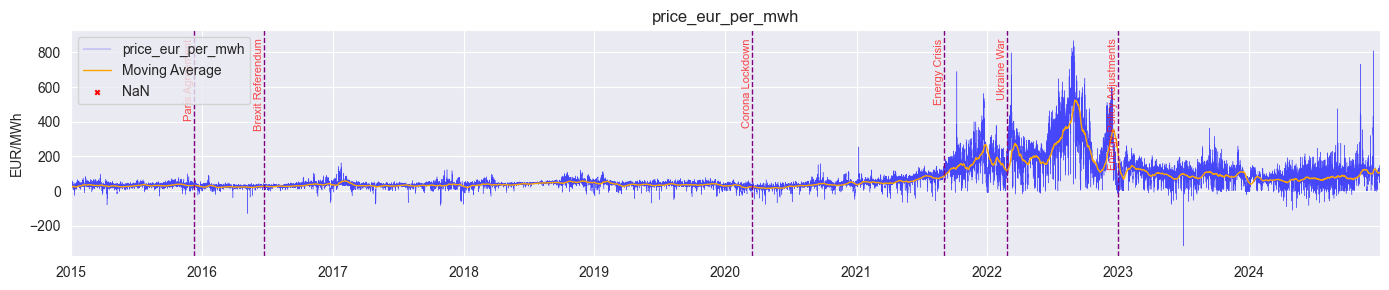

In [ ]:
# TODO: find out about one ore two more events that influenced the energy prices
# Geopolitical and economic events that had a significant impact on the German EPEX Spot price 
events = [
    ("2015-12-12", "Paris Agreement"),
    ("2016-06-23", "Brexit Referendum"),
    ("2020-03-15", "Corona Lockdown"),
    ("2021-09-01", "Energy Crisis"),
    ("2022-02-24", "Ukraine War"),
    ("2023-01-01", "Energy Policy Adjustments"),
]

plot_feature(df, "price_eur_per_mwh", ylabel="EUR/MWh", rolling_window=200, events=events)

TODO: plot these features:
    'price_eur_per_mwh',
    'forecast_net_load_mwh',
    'forecast_total_mwh',
    'forecast_wind_offshore_mwh',
    'forecast_wind_onshore_mwh',
    'forecast_solar_mwh'

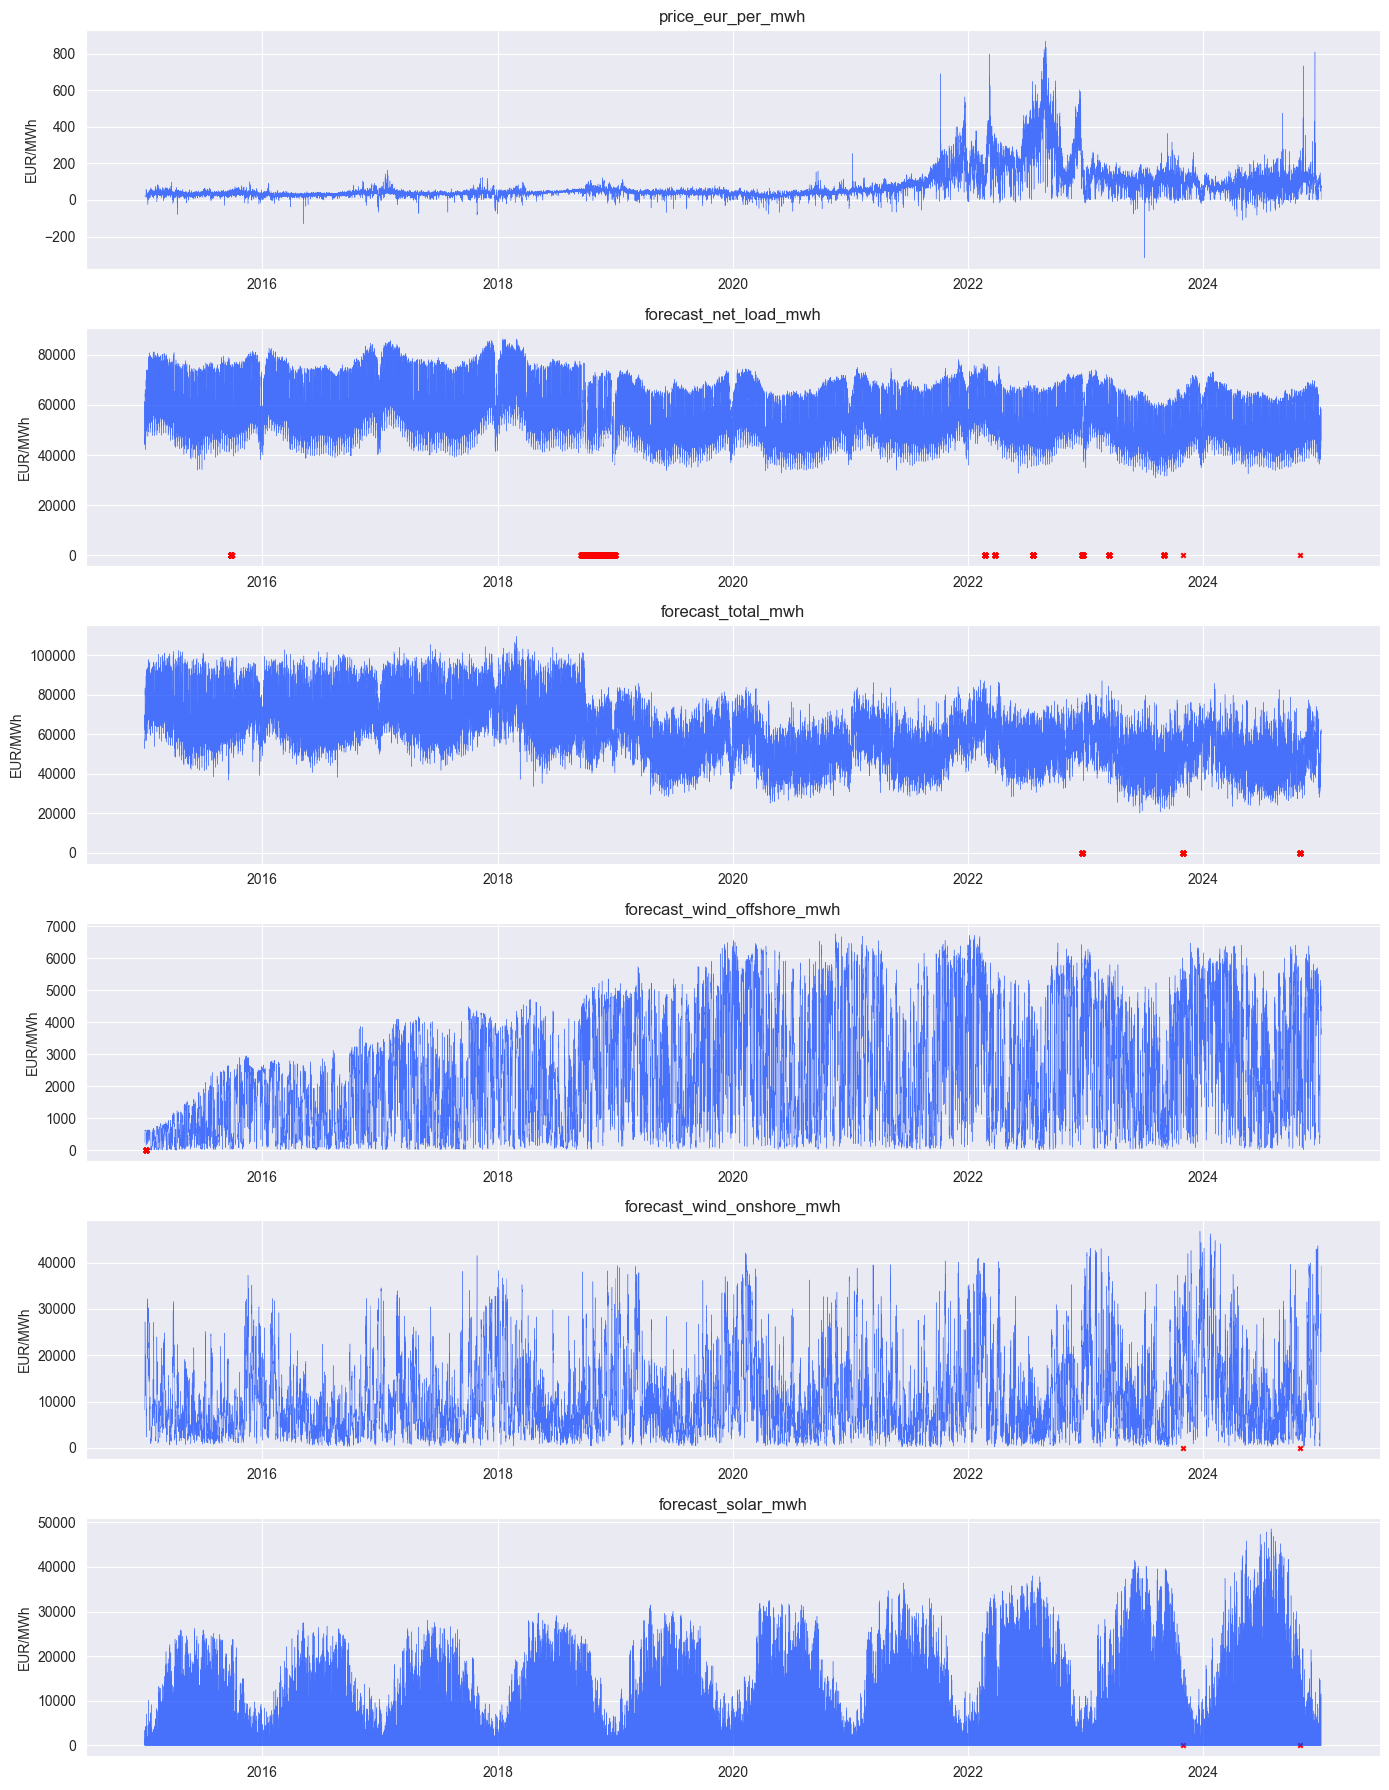

In [ ]:
# TODO: plot ...




## Correlation of Features

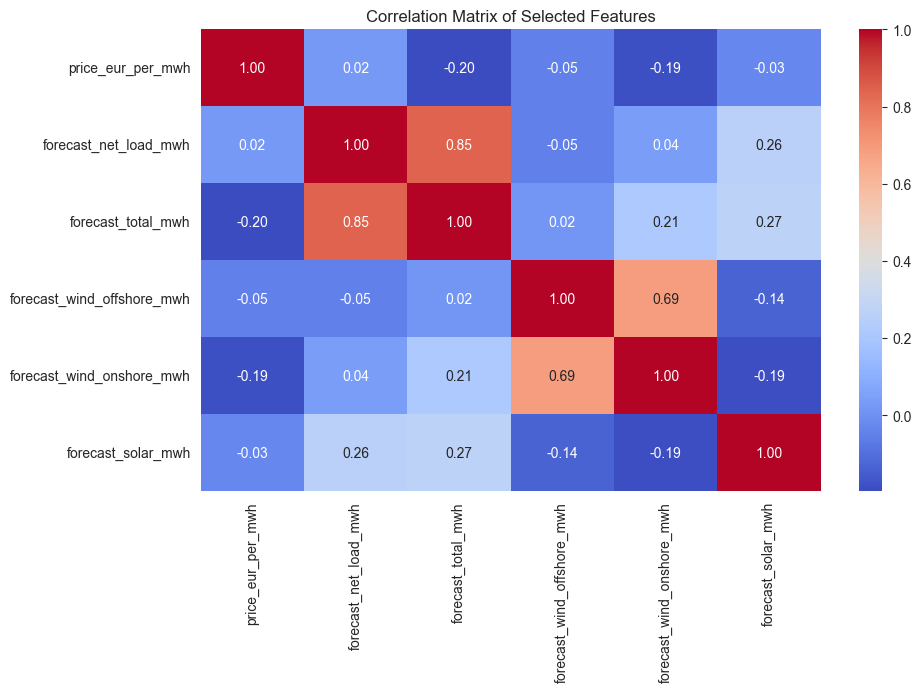

In [1295]:
# Korrelation nur für die gewählten Features
correlation_matrix = df[features_to_plot].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Selected Features")
plt.show()

## Price over Time

In [1296]:
# TODO: plot price over time

## Correlation of the features

In [1297]:
# TODO: sns.heatmap()

TODO: add small summary for each plot
- Price over Time
- Correlation of the featuers (maybe with sns.heatmap)
- Plot and explain seasonal patterns
- Plot the target variable over time
- Boxplot
- more ... ?

# <font color="RoyalBlue">6 Data Cleanup</font>
This section focuses on preparing our data for model training by handling missing values, NaN values and removing duplicates.

In [1298]:
# remove rows with NaN (because of shift)

nan_amount_before = 20 # TODO -> df.isna().sum()
print("amount of NaN values before cleanup: {}".format(nan_amount_before))
df_prices = df_prices.dropna()
nan_amount_after = 0 # TODO
print("amount of NaN values after cleanup: {}".format(nan_amount_after))

nan_amount_removed = nan_amount_before - nan_amount_after
print("So we removed {} NaN values".format(nan_amount_removed))

amount of NaN values before cleanup: 20
amount of NaN values after cleanup: 0
So we removed 20 NaN values


TODO: maybe scaling / normalising needed for numerical features?

In [1299]:
# TODO: scale or normalize values if this achieves better performance

# <font color="RoyalBlue">7 Adding Lag Features & Rolling Statistics</font>
Within this chapter, we define our feature set and the target variable that is to predict. In this regard, we will also create some new so called **lag features** and **rolling statistics** that can be used for the model training in order to gain a better performance out of the models. 

## Adding Lag Features

Lags are values from previous time steps of a time series. For example, lag_1 refers to the value of a variable exactly one time step before the current observation. Lag Features help models to learn temporal dependencies, trends, and patterns that occur over time. As a result, the quality of the predictions will be enhanced.

In [1300]:
# Create our target variable
df["price"] = df["price_eur_per_mwh"]
# TODO: do i need to remove the column "price_eur_per_mwh" here? 

# Add lag features (price 1h and 24h before)
# TODO: try out different lags and see what is best for the prediction
lags = [1, 2, 3, 24, 168]
for l in lags:
    df[f"lag_{l}"] = df["price"].shift(l)

## Adding Rolling Statistics
Rolling statistics are calculations like mean, sum or standard derivation, performed on a moving window of fixed size over sequential data. They help capture local trends and smooth out short-term fluctuations. Overall, this contributes to better model predictions.

In [1301]:
# Define columns to apply rolling statistics to
# TODO: try out different combinations and see what is best for the prediction
rolling_columns = [
    "price",
    "forecast_net_load_mwh",
    "forecast_residual_load_mwh",
    "forecast_total_mwh"
]

# Rolling windows in hours
windows = [3, 24, 168]

# Compute rolling mean and std (with shift to avoid data leakage)
for col in rolling_columns:
    for w in windows:
        df[f"{col}_roll_mean_{w}"] = df[col].shift(1).rolling(window=w).mean()
        df[f"{col}_roll_std_{w}"] = df[col].shift(1).rolling(window=w).std()

## Defining the feature set and target label
Finally, we define our feature set and specify the target value to be predicted by the model. In our case, we want to predict the `price`. For doing so, we use every feature that we have added up to this point except for the target label itself of course.

In [1302]:
# Define feature set and target variable 
X = df.drop("price", axis=1)
y = df["price"]

# Print out our DataFrames columns and data types for the last time
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   price_eur_per_mwh                         87661 non-null  float64
 1   forecast_net_load_mwh                     86362 non-null  float64
 2   forecast_residual_load_mwh                86338 non-null  float64
 3   forecast_total_mwh                        87589 non-null  float64
 4   forecast_wind_offshore_mwh                87637 non-null  float64
 5   forecast_wind_onshore_mwh                 87659 non-null  float64
 6   forecast_solar_mwh                        87659 non-null  float64
 7   forecast_other_mwh                        87565 non-null  float64
 8   hour                                      87661 non-null  int32  
 9   weekday                                   87661 non-null  int32  
 10 

# <font color="RoyalBlue">8 Model Training, Prediction and Evaluation</font>
In this section, we will split our data and finally train our first model with it. The model will predict future EPEX Spot energy prices of the German price zone by using the train data. After that, we take a look at different evaluation metrics, including the **RMSE** (Root Mean Squared Error), **MAE** (Mean Absolute Error) and **R2 score** (Coefficient of determination).



## Split the Data
First of all, we split our data into train and test data. We need to make sure that the data is not split randomly, but instead chronologically, so that the model is trained on past data and tested on future data only. This avoids so called **Data Leakage**. By taking a look at the final print statements, we can see that the train data now ranges from 2015-01-01 until 2023-01-01 and the test data ranges from 2023-01-01 until 2024-12-31.

In [1303]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# For X_train
print("X_train:")
print("  Lines:", len(X_train))
print("  Span:", X_train.index.min(), "until", X_train.index.max())

# For X_test
print("X_test:")
print("  Lines:", len(X_test))
print("  Span:", X_test.index.min(), "Span", X_test.index.max())

# For y_train
print("y_train:")
print("  Lines:", len(y_train))
print("  Span:", y_train.index.min(), "Span", y_train.index.max())

# For y_test
print("y_test:")
print("  Lines:", len(y_test))
print("  Span:", y_test.index.min(), "Span", y_test.index.max())

X_train:
  Lines: 70128
  Span: 2015-01-01 01:00:00 until 2023-01-01 08:00:00
X_test:
  Lines: 17533
  Span: 2023-01-01 09:00:00 Span 2024-12-31 23:00:00
y_train:
  Lines: 70128
  Span: 2015-01-01 01:00:00 Span 2023-01-01 08:00:00
y_test:
  Lines: 17533
  Span: 2023-01-01 09:00:00 Span 2024-12-31 23:00:00


## Create, Train and Evaluate the model (XGBRegressor)

In [1304]:
# Create the model
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100, 
    learning_rate=0.1,
)

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Print out errors
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f} EUR/MWh")
print(f"MAE: {mae:.4f} EUR/MWh")
print(f"R^2: {r2:.4f}") # TODO: 0.99 is a little too high ... there must be data leakage somewhere -> fix this

RMSE: 3.9657 EUR/MWh
MAE: 1.0400 EUR/MWh
R^2: 0.9933


To better understand how the model performed, we first need to look at some key evaluation metrics that help us quantify the prediction errors and the overall fit of the model.

## Important evaluation metrics (RMSE, MAE, R2 Score)
- The `RMSE` measures, on average, how much the predicted values differ from the actual values. The smaller the RMSE, the better the model is at making predictions.
- The `MAE` measures the absolute difference between predicted values and actual values. Unlike RMSE, it doesn't square the errors, so it treates all errors equally, without penalizing large errors more. As a result, the MAE is easier to understand, but less sensitive to outliers.
- The $R^2$-Score or `coefficient of determination` measures how well the predicted values from a regression model approximate the actual date points. The closer it is to 1, the better.

TODO: write about how the model performed

# <font color="RoyalBlue">9 Model Evaluation and Comparison</font>
In this chapter, we ... print out RMSE and similar errors ... plot each models predictions ...

TODO: Print relevant evaluation metrics for eacht model (MAE, RMSE, MAPE) and explain them briefly.

In [1305]:
# TODO: 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} EUR/MWh")

RMSE: 3.97 EUR/MWh


TODO: Plot real prices against the predicted prices for each model (probably best to do this in one plot only)

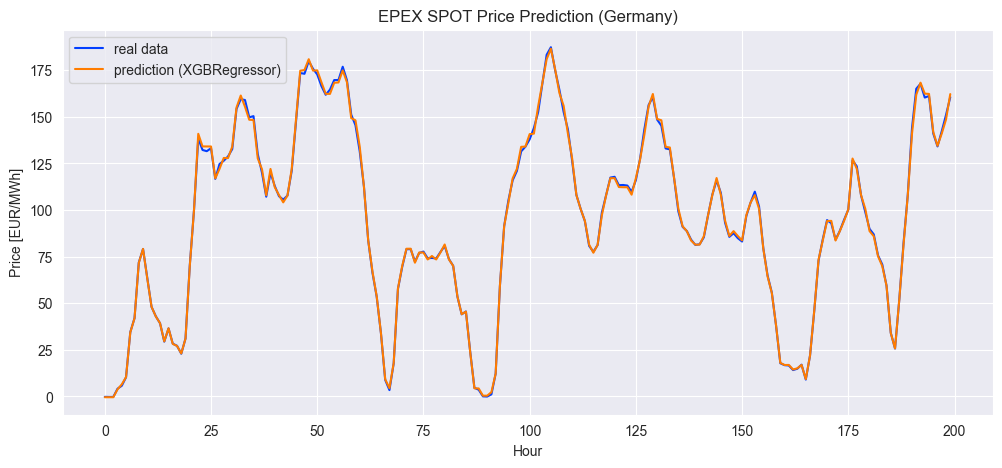

In [1306]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label="real data")
plt.plot(y_pred[:200], label="prediction (XGBRegressor)")
plt.legend()
plt.title("EPEX SPOT Price Prediction (Germany)")
plt.xlabel("Hour")
plt.ylabel("Price [EUR/MWh]")
plt.show()

# <font color="RoyalBlue">10 Conclusion</font>
TODO: add:
- Sum up this notebook
- which model performs the best? Why? 
- What errors / short cuts may have been made in this project? How does it impact the outcome?
- do certain models show specific weaknesses (for example especially bad predictions on holidays)
- list up important factors and hyper parameters that make up the models prediction quality:
    - Data split ratio (70:30, 80:20, ...)
    - Features used (especially lags and rolling statistics)
    - ...